In [1]:
# extension for automatic code formating
%load_ext jupyter_black
# extension for reloading libraries (very useful when code under development)
%reload_ext autoreload
%autoreload 2

# Simplified demonstrator of the matrix model

In [2]:
# Import of libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys, os
import pycountry
import pyprind
import scipy

plt.style.use("ggplot")

In [3]:
import ecodynelec.neighbours
import ecodynelec.energy_grouping
import ecodynelec.visualisation as viz
from ecodynelec.ecodynelec import EcoDynElec_xr
from ecodynelec.statistics_LF import *

In [5]:
import pandas as pd
import numpy as np
import xarray as xr
import scipy
import pyprind


def build_technosphere_matrix(ds_energy_t, list_energies, list_countries):
    # First piece of A matrix
    df1 = (
        ds_energy_t.value_normalised.sel(
            Electricity_sources=list(ds_energy_t.Countries.values)
            + ["External_neighbours"]
        )
        .to_dataset("Countries")
        .to_dataframe()
    )

    # Second part of matrix
    df = ds_energy_t.value_normalised.sel(
        Electricity_sources=list_energies
    ).to_dataframe()
    # Iteration over coutnries to reshape the matrix as explained: https://ecodynelec.readthedocs.io/en/latest/structure/tracking.html
    for country in list_countries:
        df[country] = df.index.get_level_values(0)
        df[country] = df[country] == country
        df[country] = df[country] * df.value_normalised
    df2 = df[list_countries]

    # Concat the two piece
    df_A = pd.concat([df1, df2], axis=0)

    # Add zero to make the matrix square
    df_A_square = pd.DataFrame(index=df_A.index, columns=df_A.index)
    df_A_square.loc[df_A.index, df_A.columns] = df_A
    df_A_square = df_A_square.fillna(0)

    return df_A_square


def invert_technology_matrix(df_A):
    df_identity = pd.DataFrame(
        data=np.identity(df_A.shape[0]),
        index=df_A.index,
        columns=df_A.columns,
    )

    df_matrix_to_invert = df_identity - df_A

    if scipy.sparse.issparse(df_matrix_to_invert):
        M = scipy.sparse.linalg.inv(df_matrix_to_invert)
    else:
        M = scipy.linalg.inv(df_matrix_to_invert)
    df_mix = pd.DataFrame(data=M, index=df_A.index, columns=df_A.columns)
    return df_mix


def format_to_xarray_dataset(df_mix, list_countries):
    df_mix = df_mix[list_countries].drop(list_countries)
    df_mix = df_mix.rename({"External_neighbours": ("External_neighbours", "Grid")})
    df_mix.index = pd.MultiIndex.from_tuples(
        df_mix.index, names=["Production_Countries", "Energies"]
    )
    df_mix.columns.name = "Consumption_Countries"
    ds_mix_t = df_mix.stack().to_xarray()
    return ds_mix_t


def compute_tracking_at_time_t(ds_energy_t, list_energies, list_countries):
    df_A = build_technosphere_matrix(
        ds_energy_t, list_energies=list_energies, list_countries=list_countries
    )
    df_mix = invert_technology_matrix(df_A)
    ds_mix_t = format_to_xarray_dataset(df_mix, list_countries)
    return ds_mix_t


def compute_tracking(ds_energy, list_energies, list_countries):
    bar = pyprind.ProgBar(ds_energy.DateTime.values.size, monitor=True, track_time=True)
    list_ds_mix_t = []
    for DateTime in ds_energy.DateTime.values:
        ds_energy_t = ds_energy.sel(DateTime=DateTime).drop("DateTime")
        ds_mix_t = compute_tracking_at_time_t(
            ds_energy_t, list_energies=list_energies, list_countries=list_countries
        )
        list_ds_mix_t.append(ds_mix_t)
        bar.update()
    ds_mix = xr.concat(list_ds_mix_t, dim="DateTime")
    ds_mix = ds_mix.assign_coords(coords={"DateTime": ds_energy.DateTime.values})
    return ds_mix

In [6]:
list_energies = ["renewable", "fossil"]
list_countries = ["A", "B", "C"]

In [7]:
# Build technosphere matrix
# First piece of A matrix
df = pd.DataFrame(
    index=list_countries,
    columns=list_countries,
    data=np.zeros(shape=(len(list_countries), len(list_countries))),
)
df.index.name = "Production_Countries"
df.columns.name = "Consumption_Countries"
df.loc["B", "A"] = 0.2
df.loc["C", "B"] = 0.4
df = pd.concat([df], axis=0, keys=["import"])
df = df.swaplevel(0, 1, 0)
df1 = df
# display(df1)

df = pd.DataFrame(index=list_energies)
df["A"] = [0.4, 0.4]
df["B"] = [0.6, 0]
df["C"] = [0, 1]
df_mix = df
# df_mix

df = pd.DataFrame(index=pd.MultiIndex.from_product([list_countries, list_energies]))

# Iteration over countries to reshape the matrix as explained: https://ecodynelec.readthedocs.io/en/latest/structure/tracking.html
for country in list_countries:
    df[country] = df.index.get_level_values(0)
    df[country] = df[country] == country
    df[country] = df[country] * df_mix.unstack()
df2 = df[list_countries]
# display(df2)

# Concat the two piece and normalise
df_A = pd.concat([df1, df2], axis=0)
df_A = df_A / df_A.sum(axis=0)
df_A = pd.concat([df_A], axis=1, keys=["import"])
df_A = df_A.swaplevel(0, 1, 1)
# display(df_A)
# Add zero to make the matrix square
df_A_square = pd.DataFrame(index=df_A.index, columns=df_A.index)
df_A_square.loc[df_A.index, df_A.columns] = df_A
df_A_square.columns.names = ["Countries", None]
df_A = df_A_square.fillna(0)
df_A

C:\Users\romai\AppData\Local\Temp\ipykernel_18656\2520051540.py:42: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_A_square.loc[df_A.index, df_A.columns] = df_A


Countries                A      B      C         A                B         \
                    import import import renewable fossil renewable fossil   
Countries                                                                    
A         import       0.0    0.0    0.0         0      0         0      0   
B         import       0.2    0.0    0.0         0      0         0      0   
C         import       0.0    0.4    0.0         0      0         0      0   
A         renewable    0.4    0.0    0.0         0      0         0      0   
          fossil       0.4    0.0    0.0         0      0         0      0   
B         renewable    0.0    0.6    0.0         0      0         0      0   
          fossil       0.0    0.0    0.0         0      0         0      0   
C         renewable    0.0    0.0    0.0         0      0         0      0   
          fossil       0.0    0.0    1.0         0      0         0      0   

Countries                   C         
                    renewable fossil  
Countries                             
A         import            0      0  
B         import            0      0  
C         import            0      0  
A         renewable         0      0  
          fossil            0      0  
B         renewable         0      0  
          fossil            0      0  
C         renewable         0      0  
          fossil            0      0

In [8]:
df_identity = pd.DataFrame(
    data=np.identity(df_A.shape[0]),
    index=df_A.index,
    columns=df_A.columns,
)

df_matrix_to_invert = df_identity - df_A
df_matrix_to_invert

Countries                A      B      C         A                B         \
                    import import import renewable fossil renewable fossil   
Countries                                                                    
A         import       1.0    0.0    0.0       0.0    0.0       0.0    0.0   
B         import      -0.2    1.0    0.0       0.0    0.0       0.0    0.0   
C         import       0.0   -0.4    1.0       0.0    0.0       0.0    0.0   
A         renewable   -0.4    0.0    0.0       1.0    0.0       0.0    0.0   
          fossil      -0.4    0.0    0.0       0.0    1.0       0.0    0.0   
B         renewable    0.0   -0.6    0.0       0.0    0.0       1.0    0.0   
          fossil       0.0    0.0    0.0       0.0    0.0       0.0    1.0   
C         renewable    0.0    0.0    0.0       0.0    0.0       0.0    0.0   
          fossil       0.0    0.0   -1.0       0.0    0.0       0.0    0.0   

Countries                   C         
                    renewable fossil  
Countries                             
A         import          0.0    0.0  
B         import          0.0    0.0  
C         import          0.0    0.0  
A         renewable       0.0    0.0  
          fossil          0.0    0.0  
B         renewable       0.0    0.0  
          fossil          0.0    0.0  
C         renewable       1.0    0.0  
          fossil          0.0    1.0

In [9]:
df_mix = invert_technology_matrix(df_A)
df_mix = df_mix.swaplevel(0, 1, 1)["import"].drop("import", axis=0, level=1)
df_mix

Countries               A    B    C
Countries                          
A         renewable  0.40  0.0  0.0
          fossil     0.40  0.0  0.0
B         renewable  0.12  0.6  0.0
          fossil     0.00  0.0  0.0
C         renewable  0.00  0.0  0.0
          fossil     0.08  0.4  1.0

C:\Users\romai\AppData\Local\Temp\ipykernel_18656\2472539294.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_A.swaplevel(0, 1, 1)["import"][list_countries].sum(axis=0, level=0).T.plot(
C:\Users\romai\AppData\Local\Temp\ipykernel_18656\2472539294.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_A.swaplevel(0, 1, 1)["import"][list_countries].sum(axis=0, level=1).T[
C:\Users\romai\AppData\Local\Temp\ipykernel_18656\2472539294.py:11: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_mix[list_countries

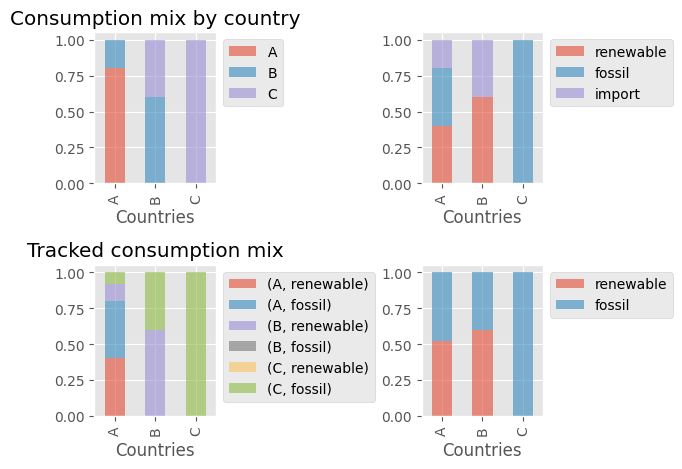

In [10]:
fig, ax = plt.subplots(2, 2)
ax = ax.ravel()
df_A.swaplevel(0, 1, 1)["import"][list_countries].sum(axis=0, level=0).T.plot(
    ax=ax[0], kind="bar", stacked=True, alpha=0.6
)
df_A.swaplevel(0, 1, 1)["import"][list_countries].sum(axis=0, level=1).T[
    ["renewable", "fossil", "import"]
].plot(ax=ax[1], kind="bar", stacked=True, alpha=0.6)
ax[0].set_title("Consumption mix by country")

df_mix[list_countries].sum(axis=0, level=1).T[["renewable", "fossil"]].plot(
    ax=ax[3], kind="bar", stacked=True, alpha=0.6
)

df_mix[list_countries].T.plot(ax=ax[2], kind="bar", stacked=True, alpha=0.6)

ax[2].set_title("Tracked consumption mix")
for axi in ax:
    axi.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()

# More export of fossil

In [13]:
# Build technosphere matrix
# First piece of A matrix
df = pd.DataFrame(
    index=list_countries,
    columns=list_countries,
    data=np.zeros(shape=(len(list_countries), len(list_countries))),
)
df.index.name = "Production_Countries"
df.columns.name = "Consumption_Countries"
df.loc["B", "A"] = 0.2
df.loc["C", "B"] = 0.4
df = pd.concat([df], axis=0, keys=["import"])
df = df.swaplevel(0, 1, 0)
df1 = df
# display(df1)

df = pd.DataFrame(index=list_energies)
df["A"] = [0.4, 0.4]
df["B"] = [0.6, 0]
df["C"] = [0.9, 0.1]
df_mix = df
# df_mix

df = pd.DataFrame(index=pd.MultiIndex.from_product([list_countries, list_energies]))

# Iteration over countries to reshape the matrix as explained: https://ecodynelec.readthedocs.io/en/latest/structure/tracking.html
for country in list_countries:
    df[country] = df.index.get_level_values(0)
    df[country] = df[country] == country
    df[country] = df[country] * df_mix.unstack()
df2 = df[list_countries]
# display(df2)

# Concat the two piece and normalise
df_A = pd.concat([df1, df2], axis=0)
df_A = df_A / df_A.sum(axis=0)
df_A = pd.concat([df_A], axis=1, keys=["import"])
df_A = df_A.swaplevel(0, 1, 1)
# display(df_A)
# Add zero to make the matrix square
df_A_square = pd.DataFrame(index=df_A.index, columns=df_A.index)
df_A_square.loc[df_A.index, df_A.columns] = df_A
df_A_square.columns.names = ["Countries", None]
df_A = df_A_square.fillna(0)
df_A

C:\Users\romai\AppData\Local\Temp\ipykernel_18656\707961160.py:42: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_A_square.loc[df_A.index, df_A.columns] = df_A


Countries                A      B      C         A                B         \
                    import import import renewable fossil renewable fossil   
Countries                                                                    
A         import       0.0    0.0    0.0         0      0         0      0   
B         import       0.2    0.0    0.0         0      0         0      0   
C         import       0.0    0.4    0.0         0      0         0      0   
A         renewable    0.4    0.0    0.0         0      0         0      0   
          fossil       0.4    0.0    0.0         0      0         0      0   
B         renewable    0.0    0.6    0.0         0      0         0      0   
          fossil       0.0    0.0    0.0         0      0         0      0   
C         renewable    0.0    0.0    0.9         0      0         0      0   
          fossil       0.0    0.0    0.1         0      0         0      0   

Countries                   C         
                    renewable fossil  
Countries                             
A         import            0      0  
B         import            0      0  
C         import            0      0  
A         renewable         0      0  
          fossil            0      0  
B         renewable         0      0  
          fossil            0      0  
C         renewable         0      0  
          fossil            0      0

In [14]:
df_identity = pd.DataFrame(
    data=np.identity(df_A.shape[0]),
    index=df_A.index,
    columns=df_A.columns,
)

df_matrix_to_invert = df_identity - df_A
df_mix = invert_technology_matrix(df_A)
df_mix = df_mix.swaplevel(0, 1, 1)["import"].drop("import", axis=0, level=1)
df_mix

Countries                A     B    C
Countries                            
A         renewable  0.400  0.00  0.0
          fossil     0.400  0.00  0.0
B         renewable  0.120  0.60  0.0
          fossil     0.000  0.00  0.0
C         renewable  0.072  0.36  0.9
          fossil     0.008  0.04  0.1

C:\Users\romai\AppData\Local\Temp\ipykernel_18656\2472539294.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_A.swaplevel(0, 1, 1)["import"][list_countries].sum(axis=0, level=0).T.plot(
C:\Users\romai\AppData\Local\Temp\ipykernel_18656\2472539294.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_A.swaplevel(0, 1, 1)["import"][list_countries].sum(axis=0, level=1).T[
C:\Users\romai\AppData\Local\Temp\ipykernel_18656\2472539294.py:11: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_mix[list_countries

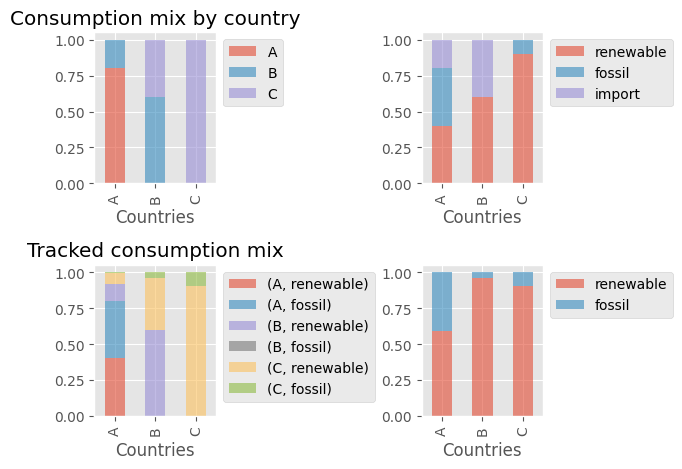

In [15]:
fig, ax = plt.subplots(2, 2)
ax = ax.ravel()
df_A.swaplevel(0, 1, 1)["import"][list_countries].sum(axis=0, level=0).T.plot(
    ax=ax[0], kind="bar", stacked=True, alpha=0.6
)
df_A.swaplevel(0, 1, 1)["import"][list_countries].sum(axis=0, level=1).T[
    ["renewable", "fossil", "import"]
].plot(ax=ax[1], kind="bar", stacked=True, alpha=0.6)
ax[0].set_title("Consumption mix by country")

df_mix[list_countries].sum(axis=0, level=1).T[["renewable", "fossil"]].plot(
    ax=ax[3], kind="bar", stacked=True, alpha=0.6
)

df_mix[list_countries].T.plot(ax=ax[2], kind="bar", stacked=True, alpha=0.6)

ax[2].set_title("Tracked consumption mix")
for axi in ax:
    axi.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()